In [1]:
print("--- 1. Setting up Environment ---")
!nvidia-smi # Check GPU status
!pip install -qq torch torchvision torchaudio Pillow
!pip install -qq datasets transformers accelerate diffusers matplotlib

import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

print("\n--- Setup complete. Libraries loaded. ---")

--- 1. Setting up Environment ---
/bin/bash: line 1: nvidia-smi: command not found

--- Setup complete. Libraries loaded. ---


In [2]:
print("\n--- 2. Defining Data Pipeline ---")

# --- CONFIGURATION ---
DATASET_NAME = "cifar10" # Small dataset for fast local testing
IMAGE_SIZE = 64
BATCH_SIZE = 16
MAX_MASK_FRACTION = 0.35 # Controls maximum size of the square mask
# ---------------------

class InpaintingDataset(Dataset):
    """Handles data acquisition, pre-processing, and on-the-fly random square mask generation."""
    def __init__(self, dataset_name, image_size):
        # Data Acquisition
        print(f"Loading dataset: {dataset_name}...")
        self.data = load_dataset(dataset_name, split="train")

        # Pre-processing Transforms
        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(), # Convert PIL Image to Tensor (C, H, W)
            T.Normalize([0.5], [0.5]) # Normalize to [-1, 1] range
        ])

        self.image_size = image_size
        self.max_mask_length = int(image_size * MAX_MASK_FRACTION)

    def __len__(self):
        return len(self.data)

    def generate_random_square_mask(self):
        """Creates a 3-channel random square mask tensor (0=masked, 1=kept)."""
        # Start with a mask of ones (keeping all pixels)
        mask = torch.ones(1, self.image_size, self.image_size)

        # 1. Determine random size
        # Ensure mask is large enough, but smaller than the maximum allowed
        mask_len = random.randint(self.max_mask_length // 4, self.max_mask_length)

        # 2. Determine random starting position (top-left corner)
        max_start = self.image_size - mask_len
        start_x = random.randint(0, max_start)
        start_y = random.randint(0, max_start)

        # 3. Apply the mask: set the square area to 0.0
        mask[:, start_y:start_y + mask_len, start_x:start_x + mask_len] = 0.0

        return mask.repeat(3, 1, 1) # Repeat for 3 color channels (C, H, W)

    def __getitem__(self, idx):
        # 1. Load and process the clean image
        original_image_pil = self.data[idx]['img'].convert("RGB")
        clean_image = self.transform(original_image_pil) # Target image (Ground Truth)

        # 2. Generate the mask
        mask = self.generate_random_square_mask()

        # 3. Create the masked image (Input to the model)
        masked_image = clean_image * mask

        dummy_text = "a high-quality photo"

        return {
            "clean_image": clean_image,
            "mask": mask,
            "masked_image": masked_image,
            "text": dummy_text
        }

print("--- Data Pipeline Defined. ---")


--- 2. Defining Data Pipeline ---
--- Data Pipeline Defined. ---



--- 3. Running and Verifying Pipeline ---
Loading dataset: cifar10...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Clean Image Batch Shape: torch.Size([16, 3, 64, 64])
Masked Image Batch Shape: torch.Size([16, 3, 64, 64])


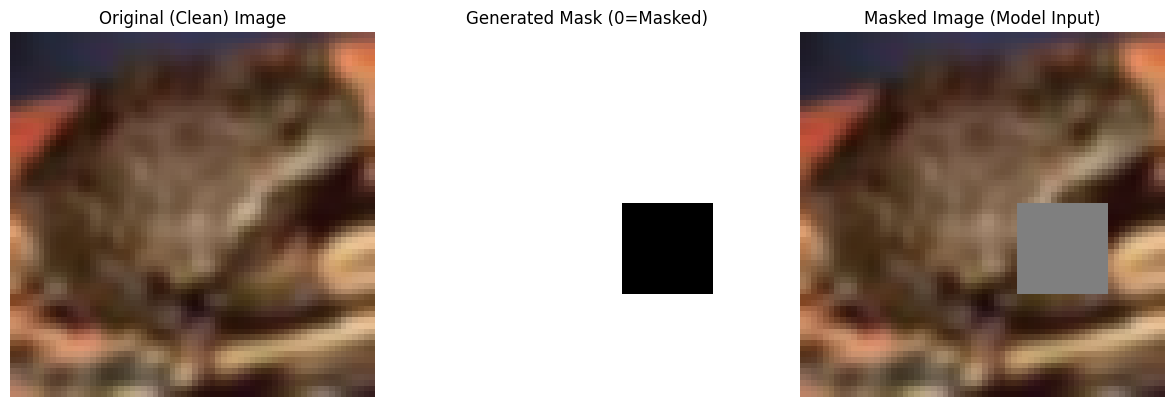


--- Week 2 Pipeline Complete and Verified. ---


In [3]:
print("\n--- 3. Running and Verifying Pipeline ---")

# Create Dataset and DataLoader
inpainting_dataset = InpaintingDataset(dataset_name=DATASET_NAME, image_size=IMAGE_SIZE)
train_dataloader = DataLoader(
    inpainting_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

# --- Verification: Inspect a sample batch ---
sample_batch = next(iter(train_dataloader))
print(f"Clean Image Batch Shape: {sample_batch['clean_image'].shape}")
print(f"Masked Image Batch Shape: {sample_batch['masked_image'].shape}")

# --- Visualization ---

# Helper function to convert normalized tensor back to plottable image (H, W, C format)
def denormalize_and_reformat(tensor):
    return (tensor.numpy().transpose(1, 2, 0) * 0.5 + 0.5).clip(0, 1)

# Get the first sample from the batch
img = sample_batch['clean_image'][0]
masked_img = sample_batch['masked_image'][0]
mask = sample_batch['mask'][0]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original (Clean) Image")
plt.imshow(denormalize_and_reformat(img))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Generated Mask (0=Masked)")
plt.imshow(mask[0], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Masked Image (Model Input)")
plt.imshow(denormalize_and_reformat(masked_img))
plt.axis('off')

plt.tight_layout()
plt.show()

print("\n--- Week 2 Pipeline Complete and Verified. ---")